# Examen Práctico 

#### 3670 COM:01-3900 | Ciencia de datos | 2024 C2

Alumnos:

## Enunciado

Se tiene un dataset con datos del historial de solicitantes a quienes se le otorgaron créditos y su situación final como deudores o pagadores. La entidad tiene que determinar a quienes entregar o no un crédito en función de su propensión a caer en "default". Desarrolle un proceso que clasifique deudores y pagadores. Observe que la clase de interés es "default", y debido a nuevas políticas de encaje bancario se ha expresado el objetivo de evitar tanto como sea posible entregar créditos a deudores (a costa naturalmente de perder algún posible crédito a pagadores). Maximice la métrica correspondiente sin modificar threshold.

 Las columnas tienen nombres descriptivos, pero para mas información:

Importe: Cuando dinero esta pidiendo prestado</BR>
añosPago: Tiempo para pagar el crédito</BR>
IngresoAnuales: Ingresos anuales del solicitante</BR>
RelacionIngresoDeuda: Ratio entre sus ingresos y la deuda</BR>
RelacionCuotaDeuda: Ratio entre sus ingresos y la cuota</BR>
PendienteEnTarjeta: Pendiente de pago en tarjetas de crédito</BR>
UsoCreditoTarjeta: Volumen de dinero que maneja con sus instrumentos de crédito</BR>
Objetivo: ¿Para que quiere el préstamos?</BR>
esPropietario: ¿Es propietario del su casa?</BR>
FueVeraz: ¿Alguna vez estuvo en el veraz?</BR>
TuvoEmbargo: ¿Tuvo algun embargo o situación judicial?</BR>
Cuentas: Cantidad de cuentas que maneja</BR>
PuntuacionGeneral: Puntuación crediticia otorgada por un organismo regular</BR>
Default: Si pagó o no el crédito</BR>
AntiguedadLaboral: Antiguedad laboral</BR>

## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general. 

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR> 



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente, recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos. Ej: "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si EVALUACION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando al fuga de datos).Puede dejar funcionando implementaciones alternativas que no prosperaron en notebooks separados. En cuanto comience con el desarrollo informe a los docentes el nombre del repositorio.


## Evaluacion final - Docente + Alumno

In [11]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt


Lectura de los datos

In [12]:
df = pd.read_csv(STUDENTDATAFILE)

Declaramos transformaciones de pipeline que vimos en clase y otras que desarrollamos en TPs

In [4]:
# Imputer con mean por defecto
class ColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean"), columns=None):
        self.imputer = imputer
        self.columns = columns

    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self    
    def get_feature_names_out(self):
        return self.imputer.get_feature_names_out()
    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.columns] = self.imputer.transform(X[self.columns])
        return Xc
    
# Imputer con mean por defecto sobre todas las columnas
class AllColumnImputer(BaseEstimator, TransformerMixin):
    def __init__(self, imputer=SimpleImputer(strategy="mean")):
        self.imputer = imputer

    def fit(self, X, y=None):
        self.numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
        self.imputer.fit(X[self.numeric_columns])
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X[self.numeric_columns] = self.imputer.transform(X[self.numeric_columns])
        return X

# Se dropean las columnas que tengan un 70% de valores nulos
class ColumnDropNulls(BaseEstimator, TransformerMixin):
    def __init__(self, treshold=70):
        self.treshold = treshold
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        overseventy = (Xc.isnull().sum()/len(Xc)*100).where(lambda x: x > self.treshold).dropna()
        names = overseventy.index.tolist()
        for name in names:
            Xc.drop(columns=[name], inplace=True)
        return Xc

# Se qutian las columnas que tienen mas del 70% de valores iguales
class ColumnDropUnique(BaseEstimator, TransformerMixin):
    def __init__(self, treshold=70):
        self.treshold = treshold
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        unique = (Xc.nunique()/len(Xc)*100).where(lambda x: x > self.treshold).dropna()
        names = unique.index.tolist()
        outputs = [Xc]
        print('DEBUG: ', names)
        for name in names:
            aux = outputs[-1]
            Xc.drop(columns=[name], inplace=True)

        return Xc

# Se quitan las columnas que se pasen por parametro
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        Xc = X.copy()
        Xc.drop(columns=self.columns, inplace=True)
        return Xc

# OneHotEncoder para columnas que se pasen por parametro
class ColumnOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, encoder=OneHotEncoder(drop='first', sparse_output=False), columns=None):
        self.encoder = encoder
        self.columns = columns

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self    
    def get_feature_names_out(self):
        return self.encoder.get_feature_names_out()
    
    def transform(self, X):
        Xc = X.copy()
        Xc.loc[:, self.encoder.get_feature_names_out()] = self.encoder.transform(Xc[self.columns])
        Xc.drop(columns=self.columns, inplace=True)
        return Xc

# Inspección inicial de los datos

In [13]:
df.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7
3,33425,5,75000,20.85,14.08580,25807,60.7,Deuda,Hipoteca,0,1,14,4.0,paid off,11
4,15000,5,55000,7.66,9.43025,8452,49.4,Deuda,Alquiler,1,1,10,1.4,default,4


Calculamos la cantidad de valores nulos por columna

In [14]:
# Vemos que no hay columnas con valores nulos
(df.isnull().sum()/len(df)*100)

Importe                 0.0
añosPago                0.0
IngresoAnuales          0.0
RelacionIngresoDeuda    0.0
RelacionCuotaDeuda      0.0
PendienteEnTarjeta      0.0
UsoCreditoTarjeta       0.0
Objetivo                0.0
esPropietario           0.0
FueVeraz                0.0
TuvoEmbargo             0.0
Cuentas                 0.0
PuntuacionGeneral       0.0
Default                 0.0
AntiguedadLaboral       0.0
dtype: float64

Calculamos la cantidad de valores unicos por columna, para detectar identificadores unicos que no aportan valor predictivo

In [15]:
# Relacion CuotaDeuda parece no aportar mucho
(df.nunique()/len(df)*100)

Importe                  3.072987
añosPago                 0.005881
IngresoAnuales          12.465447
RelacionIngresoDeuda    10.127625
RelacionCuotaDeuda      89.925307
PendienteEnTarjeta      60.971593
UsoCreditoTarjeta        3.114156
Objetivo                 0.035288
esPropietario            0.011763
FueVeraz                 0.005881
TuvoEmbargo              0.005881
Cuentas                  0.138211
PuntuacionGeneral        0.102923
Default                  0.005881
AntiguedadLaboral        0.035288
dtype: float64

Analizamos la matriz de correlacion de las columnas con valores enteros y floteantes

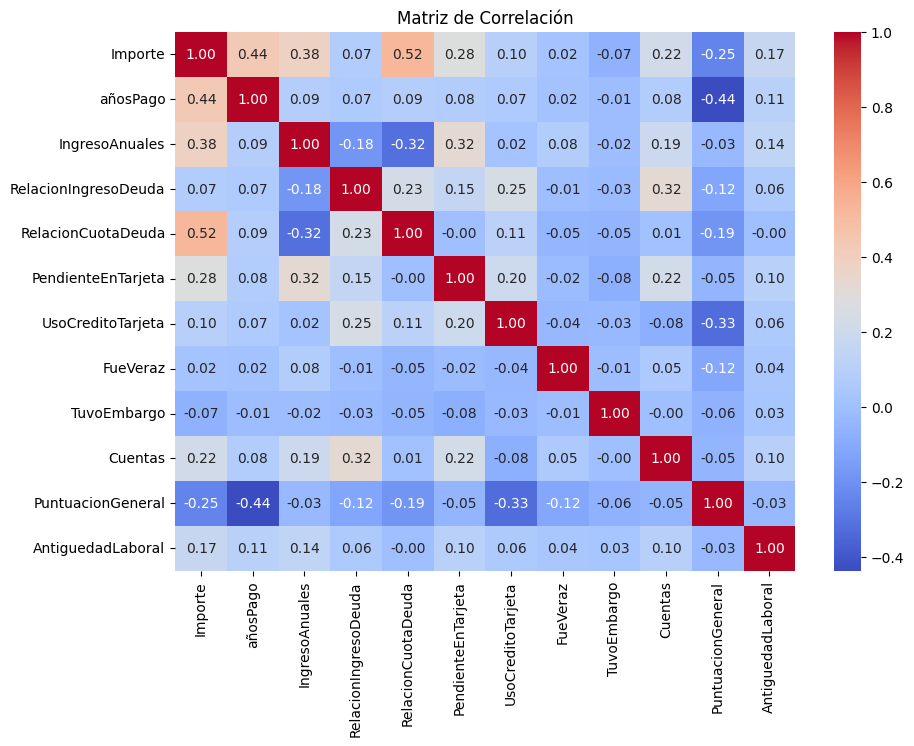

In [16]:
mat = df.select_dtypes(include=['int', 'float']).corr()

fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(mat, annot=True, cmap='coolwarm', fmt=".2f",  ax=ax)
plt.title('Matriz de Correlación')
plt.show()

# RESOLUCIÓN

Obtenemos los quartiles de las columnas numéricas

In [17]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Importe,34006.0,NaN,NaN,NaN,13172.604099,8101.327372,500.0,7000.0,11500.0,18000.0,35000.0
añosPago,34006.0,NaN,NaN,NaN,3.503441,0.868015,3.0,3.0,3.0,5.0,5.0
IngresoAnuales,34006.0,NaN,NaN,NaN,68136.860583,45495.765008,3500.0,42000.0,60000.0,82000.0,1200000.0
RelacionIngresoDeuda,34006.0,NaN,NaN,NaN,16.110743,7.59336,0.0,10.46,16.01,21.56,38.6
RelacionCuotaDeuda,34006.0,NaN,NaN,NaN,8.026282,4.267497,0.048892,4.659375,7.49215,10.935325,43.5456
PendienteEnTarjeta,34006.0,NaN,NaN,NaN,14973.249074,21086.541027,0.0,5676.5,10807.5,18668.75,1743266.0
UsoCreditoTarjeta,34006.0,NaN,NaN,NaN,56.087961,25.437684,0.0,38.0,58.5,76.5,119.0
Objetivo,34006,12,Deuda,19141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
esPropietario,34006,4,Hipoteca,15705,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FueVeraz,34006.0,NaN,NaN,NaN,0.143239,0.350322,0.0,0.0,0.0,0.0,1.0


Vemos que la diferencia entre 75% y Max para las columnas PuntuacionGeneral, IngresoAnuales, RelacionIngresoDeuda y PendienteEnTarjeta son muy altas, posiblemente tengan outliers. 
Ignoramos la columna RelacionCuotaDeuda porque sabemos que la vamos a eliminar.

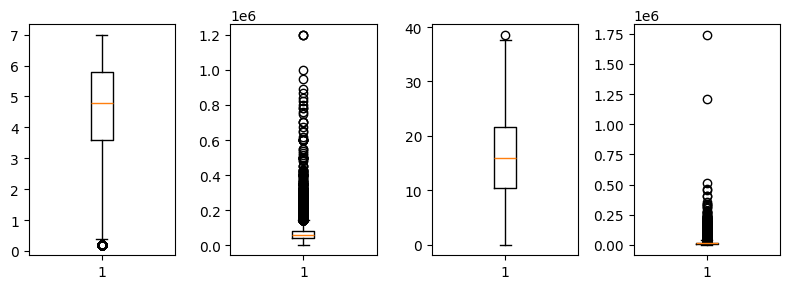

In [18]:
bxColumns = ["PuntuacionGeneral", "IngresoAnuales", "RelacionIngresoDeuda", "PendienteEnTarjeta"]
fig, axs = plt.subplots(1, len(bxColumns), figsize=(8, 3))
for c,i in zip(bxColumns, range(len(bxColumns))):
    axs[i].boxplot(df[c])
   
plt.tight_layout()
plt.show()

1. PuntuacionGeneral tiene varios casos con ~0 que no parecen ser representativos del dataset.  
2. IngresoAnuales tiene mucho desvío  
3. RelacionIngresoDeuda y PendienteEnTarjeta tienen outliers muy altos.   

Vamos por partes

### PuntacionGeneral tiene outliers en 0 no representativos?

<Axes: >

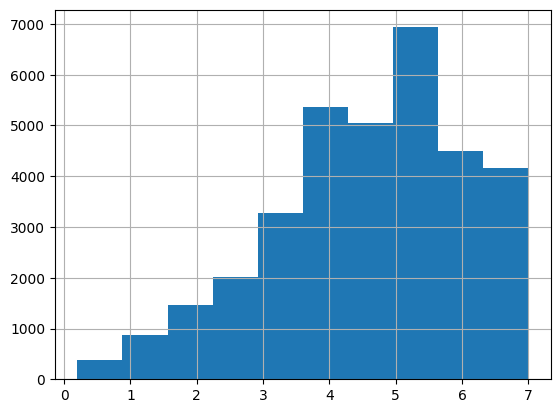

In [19]:
df['PuntuacionGeneral'].hist()

In [20]:
# Veamos el porcentaje de valores <N para 0 hasta 7
for i in range(8):
    print(f"Porcentaje de valores <{i}: {len(df[df['PuntuacionGeneral'] < i])/len(df)*100}")

Porcentaje de valores <0: 0.0
Porcentaje de valores <1: 1.1321531494442156
Porcentaje de valores <2: 5.35493736399459
Porcentaje de valores <3: 13.906369464212197
Porcentaje de valores <4: 30.471093336470034
Porcentaje de valores <5: 54.149267776274776
Porcentaje de valores <6: 80.8122096100688
Porcentaje de valores <7: 96.14773863435863


Los valores <1 no son representativos puesto que conforman menos del 2.5% marginal de la distribución. Podemos sacarlos como outliers

### IngresosAnuales tiene mucho desvío?

In [21]:
df.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7
3,33425,5,75000,20.85,14.08580,25807,60.7,Deuda,Hipoteca,0,1,14,4.0,paid off,11
4,15000,5,55000,7.66,9.43025,8452,49.4,Deuda,Alquiler,1,1,10,1.4,default,4


<Axes: >

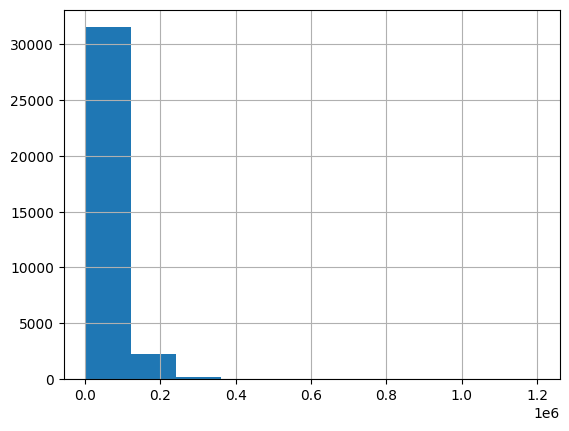

In [22]:
df['IngresoAnuales'].hist()

Notamos que la escala esta en 1x10^6, esto es porque hay 1 outlier con un ingreso anual privilegiado de 1.2 millones. El bin de la izqauierda está concentrando todos los ingresos entre 0 y 200.000, generando el sesgo a izquierda del gráfico.  
Podemos graficar el histograma sin los extremos 5%

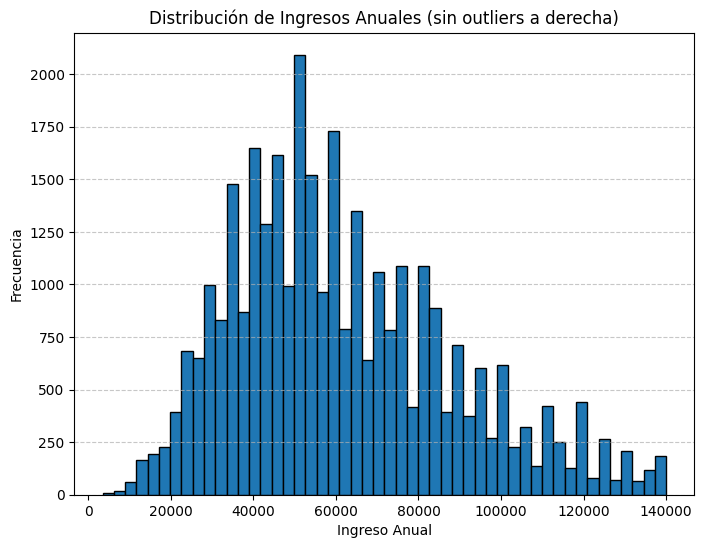

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(df['IngresoAnuales'], bins=50, range=(df['IngresoAnuales'].min(), df['IngresoAnuales'].quantile(0.95)), edgecolor='black')
plt.title('Distribución de Ingresos Anuales (sin outliers a derecha)')
plt.xlabel('Ingreso Anual')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Debemos eliminar los outliers de la columna IngresoAnuales

### RelacionIngresoDeuda y PendienteEnTarjeta tienen outliers muy altos?

<Axes: >

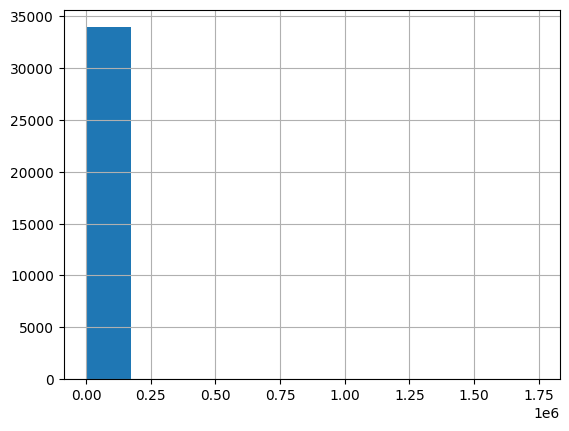

In [24]:
df['PendienteEnTarjeta'].hist()

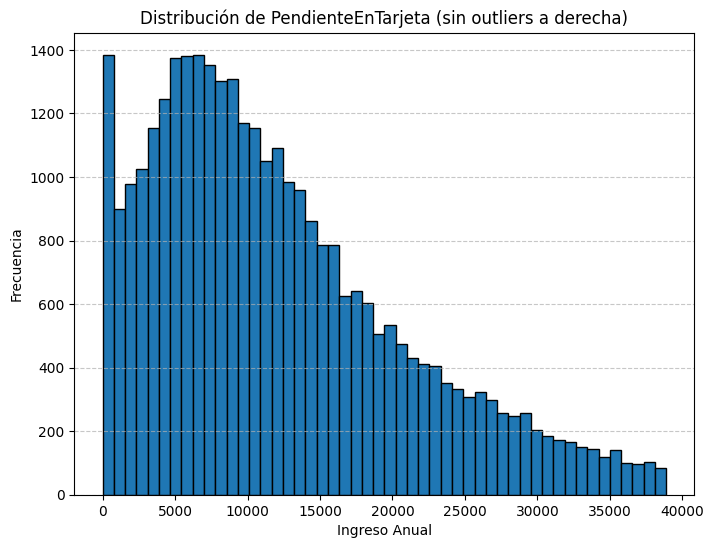

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(df['PendienteEnTarjeta'], bins=50, range=(df['PendienteEnTarjeta'].min(), df['PendienteEnTarjeta'].quantile(0.95)), edgecolor='black')
plt.title('Distribución de PendienteEnTarjeta (sin outliers a derecha)')
plt.xlabel('Ingreso Anual')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Mismo analisis que antes, PendienteEnTarjeta tiene outliers que quitar

<Axes: >

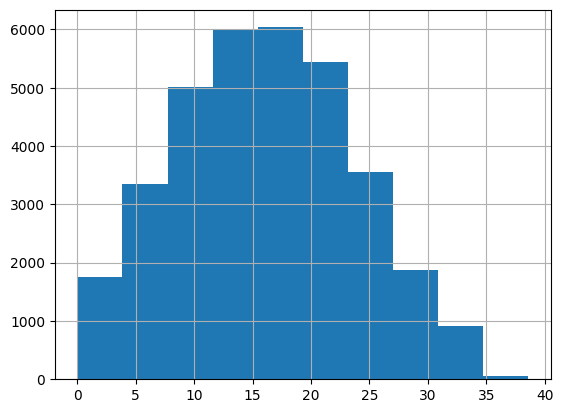

In [26]:
df['RelacionIngresoDeuda'].hist()

No parece estar sesgada la distribución de RelacionIngresoDeuda, sólo tiene un punto en 39

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

# Creamos una clase para remover outliers de una columna y reemplazarlos por NaN, para luego imputarlos
class ColumnOutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, column, method='iqr', factor=1.5, replace_with_nan=False):
        self.column = column
        self.method = method
        self.factor = factor
        self.replace_with_nan = replace_with_nan

    def fit(self, X, y=None):
        if self.method == 'iqr':
            q1 = X[self.column].quantile(0.25)
            q3 = X[self.column].quantile(0.75)
            self.lower_bound = q1 - self.factor * (q3 - q1)
            self.upper_bound = q3 + self.factor * (q3 - q1)
        elif self.method == 'zscore':
            self.mean = X[self.column].mean()
            self.std = X[self.column].std()
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if self.method == 'iqr':
            mask = (X[self.column] >= self.lower_bound) & (X[self.column] <= self.upper_bound)
        elif self.method == 'zscore':
            z_scores = (X[self.column] - self.mean) / self.std
            mask = (z_scores >= -self.factor) & (z_scores <= self.factor)
        
        if self.replace_with_nan:
            X.loc[~mask, self.column] = float('nan')
        else:
            X = X[mask]
        
        return X

class RemoveAllOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, method='iqr', factor=1.5, replace_with_nan=False):
        self.method = method
        self.factor = factor
        self.replace_with_nan = replace_with_nan
        self.bounds = {}

    def fit(self, X, y=None):
        numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
        for column in numeric_columns:
            if self.method == 'iqr':
                q1 = X[column].quantile(0.25)
                q3 = X[column].quantile(0.75)
                lower_bound = q1 - self.factor * (q3 - q1)
                upper_bound = q3 + self.factor * (q3 - q1)
                self.bounds[column] = (lower_bound, upper_bound)
            elif self.method == 'zscore':
                mean = X[column].mean()
                std = X[column].std()
                lower_bound = mean - self.factor * std
                upper_bound = mean + self.factor * std
                self.bounds[column] = (lower_bound, upper_bound)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for column, (lower_bound, upper_bound) in self.bounds.items():
            if self.method == 'iqr':
                mask = (X[column] >= lower_bound) & (X[column] <= upper_bound)
            elif self.method == 'zscore':
                mask = (X[column] >= lower_bound) & (X[column] <= upper_bound)
            
            if self.replace_with_nan:
                X.loc[~mask, column] = float('nan')
            else:
                X = X[mask]
        
        return X


In [28]:
X = df.drop(columns='Default')
y = (df['Default'] == 'default').astype(int)  # Convertir a binario para MLPClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Definir clasificadores
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'MLPClassifier': MLPClassifier(max_iter=500, hidden_layer_sizes=(64, 32), activation='relu', solver='adam'),
    'NaiveBayes': GaussianNB()
}

pl = Pipeline(steps=[
     # ('drop', ColumnDropper(columns=['RelacionCuotaDeuda'])), # Dropeamos la columna porque vimos que tiene muchos valroes unicos
     ("one_hot", ColumnOneHot(columns=['Objetivo', 'esPropietario'])),
     ("outlier", ColumnOutlierRemover(column='IngresoAnuales', method='iqr', factor=1.5, replace_with_nan=True)),
     ("outlier2", ColumnOutlierRemover(column='PendienteEnTarjeta', method='iqr', factor=1.5, replace_with_nan=True)),
     ("outlier3", ColumnOutlierRemover(column='PuntuacionGeneral', method='iqr', factor=1.5, replace_with_nan=True)),
     ("imputer", ColumnImputer(columns=['IngresoAnuales', 'PendienteEnTarjeta', 'PuntuacionGeneral'])),
     ('scaler', StandardScaler()), 
     ('classifier', RandomForestClassifier())
])


# Definir parámetros para cada clasificador
param_grid = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__max_depth': [10, 11, 12, 13, 14, 15]
    },
    {
        'classifier': [GradientBoostingClassifier()],
        'classifier__n_estimators': [100, 150],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [10, 11, 12, 13, 14, 15]
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [10, 11, 12, 13, 14, 15],
        'classifier__criterion': ['gini', 'entropy']
    },
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1, 10, 15, 20],
        'classifier__penalty': ['l2']
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10, 15, 20],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier': [MLPClassifier(max_iter=500)],
        'classifier__hidden_layer_sizes': [(32, 16, 8), (64, 32, 16, 8)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam', 'sgd'],
        'classifier__learning_rate': ['constant', 'adaptive']
    },
    {
        'classifier': [GaussianNB()]
    }
]

# Realizar la búsqueda con GridSearchCV
grid_search = GridSearchCV(pl, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Mejor modelo: {type(best_model.named_steps['classifier']).__name__}")
print("Mejores parámetros:", best_params)

# Evaluar en el conjunto de prueba
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Mejor modelo: RandomForestClassifier
Mejores parámetros: {'classifier': RandomForestClassifier(), 'classifier__max_depth': 11}
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      5069
           1       0.64      0.66      0.65      5133

    accuracy                           0.64     10202
   macro avg       0.64      0.64      0.64     10202
weighted avg       0.64      0.64      0.64     10202



Luego de quitar los outliers, vemos una mejora muy pequeña en Recall y F1, pero no en accuracy.  
Este experimento lo hicimos imputando los outliers de todas las columnas como también sólo de las columnas analizadas, con SimpleImputer usando mean y con KNNImputer, sin diferencias significativas.

In [29]:
print(best_params)

{'classifier': RandomForestClassifier(), 'classifier__max_depth': 11}


### Análisis del target

In [30]:
print(y_train.value_counts(normalize=True)) #Está desbalanceado el target? Parece que no


Default
0    0.501344
1    0.498656
Name: proportion, dtype: float64


In [31]:
EVALUACION = False
best_clf = grid_search.best_estimator_ #Asignar aqui el mejor clasificador posible (previamente entrenado)
#best_clf = pl
#Leemos el dataset de evaluación, simulando producción
if EVALUACION==False:
    df = pd.read_csv(STUDENTDATAFILE)
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv(EVALDATAFILE)
#Dividimos en target y predictoras

X_Eval = df.drop("Default", axis=1)
y_Eval = (df['Default'] == 'default').astype(int)  # Convertir a binario

#Evaluación final

y_pred = best_clf.predict(X_Eval) # esto debe ser un pipeline completo
print(classification_report(y_Eval, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      5069
           1       0.64      0.66      0.65      5133

    accuracy                           0.64     10202
   macro avg       0.64      0.64      0.64     10202
weighted avg       0.64      0.64      0.64     10202

